In [33]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [34]:
# PROCESS A: LOAD DATA
# Step A1: Load the Data
print("loading data...")
with open(r'C:\Users\Jeryl Salas\OneDrive\Documents\AI 211 Computational Linear Algebra\transformers\group1_nature.tsv', encoding='utf-8') as file:
    lines = file.readlines()

# Step A2: Preprocess the Data
print("processing data...")
data = [line.strip().split('\t') for line in lines]
source_sentences, target_sentences = zip(*data)
source_sentences = [sentence.lower() for sentence in source_sentences]
target_sentences = [sentence.lower() for sentence in target_sentences]

# Step A3: Tokenization (using a simple split for demonstration)
source_sentences_2 = [sentence.split() for sentence in source_sentences]
target_sentences_2 = [sentence.split() for sentence in target_sentences]

# Step A4: Create Vocabulary
source_vocab = {word: idx + 1 for idx, word in enumerate(set(np.concatenate(source_sentences_2)))}
target_vocab = {word: idx + 1 for idx, word in enumerate(set(np.concatenate(target_sentences_2)))}


# Step A5: Numericalize the Data
source_sentences_numeric = [
    [source_vocab[word] for word in sentence] for sentence in source_sentences_2
]
target_sentences_numeric = [
    [target_vocab[word] for word in sentence] for sentence in target_sentences_2
]

print("\nLength of source vocabukary.", len(source_vocab))
print("Maximum index in source sentences:", max(np.concatenate(source_sentences_numeric)))
print("Length of target vocabulary.", len(target_vocab))
print("Maximum index in target sentences:", max(np.concatenate(target_sentences_numeric)))


# Step A6: Padding and splitting
max_length = max(max(len(sentence) for sentence in source_sentences_numeric),
                max(len(sentence) for sentence in target_sentences_numeric))
source_sentences_padded = [sentence + [0] * (max_length - len(sentence)) for sentence in source_sentences_numeric]
target_sentences_padded = [sentence + [0] * (max_length - len(sentence)) for sentence in target_sentences_numeric]
split_idx = int(len(source_sentences_padded) * 0.9)
train_source, test_source = source_sentences_padded[:split_idx], source_sentences_padded[split_idx:]
train_target, test_target = target_sentences_padded[:split_idx], target_sentences_padded[split_idx:]
output_folder = r'C:\Users\Jeryl Salas\OneDrive\Documents\AI 211 Computational Linear Algebra\transformers'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Step A8: Save Processed Data and Vocabularies
print("saving processed data on .txt files")
np.savetxt(os.path.join(output_folder, 'train_source.txt'), train_source, fmt='%d')
np.savetxt(os.path.join(output_folder, 'train_target.txt'), train_target, fmt='%d')
np.savetxt(os.path.join(output_folder, 'test_source.txt'), test_source, fmt='%d')
np.savetxt(os.path.join(output_folder, 'test_target.txt'), test_target, fmt='%d')
np.save(os.path.join(output_folder, 'source_vocab.npy'), source_vocab)
np.save(os.path.join(output_folder, 'target_vocab.npy'), target_vocab)


loading data...
processing data...

Length of source vocabukary. 4146
Maximum index in source sentences: 4146
Length of target vocabulary. 4171
Maximum index in target sentences: 4171
saving processed data on .txt files


In [35]:
# PROCESS B: DEFINE HYPERPARAMETERS
d_model = 256
num_heads = 8
drop_prob = 0.1
batch_size = 64
max_sequence_length = max(len(seq) for seq in train_source)
ffn_hidden = 2048
num_layers = 5
vocab_size = len(source_vocab) + 1
tag_vocab_size = vocab_size


In [36]:
# PROCESS C: DEFINE FUNCTIONS
# STEP C1: Choose what device to use
def choose_device():
    if torch.cuda.is_available():
        #print("We will use cuda...")
        return torch.device('cuda')
    else:
        #print("We will use cpu...")
        return torch.device('cpu')


# STEP C2: Computation functions
def linear_act_funct(input_tensor, weight, bias=None):
    output_tensor = torch.matmul(input_tensor, weight.t())
    if bias is not None:
        output_tensor += bias
    return output_tensor


def scal_dot_prod(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1).expand(scaled.size(0), scaled.size(1), -1, -1)
        scaled = scaled + mask

    attention_raw = scaled - torch.max(scaled, dim=-1, keepdim=True)[0]
    attention = torch.exp(attention_raw) / torch.sum(torch.exp(attention_raw), dim=-1, keepdim=True)

    values = torch.matmul(attention, v)

    return values, attention

def relu_act_funct(input_tensor):
    return torch.max(input_tensor, torch.zeros_like(input_tensor))

def softmax_act_funct(logits, dim=-1):
    exp_logits = torch.exp(logits - torch.max(logits, dim, keepdim=True).values)
    sum_exp_logits = exp_logits.sum(dim, keepdim=True)
    softmax_result = exp_logits / sum_exp_logits
    return softmax_result

def dropout(input_tensor, p=0.1):
    mask = (torch.rand_like(input_tensor) > p).float()
    output_tensor = input_tensor * mask / (1 - p)

    return output_tensor

def cross_entropy_loss(logits, targets, ignore_index=None):
    probabilities = softmax_act_funct(logits, dim=-1)
    log_probabilities = torch.log(torch.clamp(probabilities, min=1e-20))
    loss = -log_probabilities.gather(dim=-1, index=targets.unsqueeze(-1))

    if ignore_index is not None:
        mask = targets != ignore_index
        loss = loss[mask]

    return loss

In [37]:
# PROCESS D: FUCNTIONS FOR EMBEDDINGS
# STEP D1: INPUT EMBEDDING
class Input_Embedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, start, end, padding):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.position_encoder = pos_encode(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.start = start
        self.end = end
        self.padding = padding
    
    def batch_tokenize(self, batch, start, end):

        def tokenize(sentence, start, end):
            sentence_word_indicies = [self.language_to_index[token] for token in list(sentence)]
            if start:
                sentence_word_indicies.insert(0, self.language_to_index[self.start])
            if end:
                sentence_word_indicies.append(self.language_to_index[self.end])
            for _ in range(len(sentence_word_indicies), self.max_sequence_length):
                sentence_word_indicies.append(self.language_to_index[self.padding])
            return torch.tensor(sentence_word_indicies)

        tokenized = []
        for sentence_num in range(len(batch)):
           tokenized.append( tokenize(batch[sentence_num], start, end) )
        tokenized = torch.stack(tokenized)
        return tokenized.to(choose_device())
    
    def forward(self, x, start, end):
        x = self.batch_tokenize(x, start, end)
        x = self.embedding(x)
        pos = self.position_encoder().to(choose_device())
        x = self.dropout(x + pos)
        return x

# STEP D2: POSITIONAL EMBEDDING
class pos_encode(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE


In [38]:
# PROCESS E: FUNCTIONS FOR ATTENTION
# STEP E1: MULTI-HEAD ATTENTION
class multi_head_attention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_weight = torch.nn.Parameter(torch.randn(3 * d_model, d_model))
        self.qkv_bias = torch.nn.Parameter(torch.zeros(3 * d_model))
        self.linear_weight = torch.nn.Parameter(torch.randn(d_model, d_model))
        self.linear_bias = torch.nn.Parameter(torch.zeros(d_model))

    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        
        # Manually compute qkv using the learned weights and biases
        qkv = linear_act_funct(x.view(-1, d_model), self.qkv_weight, self.qkv_bias)
        qkv = qkv.view(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scal_dot_prod(q, k, v, mask)
        values = values.view(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        out = linear_act_funct(values.view(-1, self.num_heads * self.head_dim), self.linear_weight, self.linear_bias)
        out = out.view(batch_size, max_sequence_length, self.d_model)

        return out
    
# STEP E2: MULTI-HEAD CROSS ATTENTION
class multi_head_cross_attention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.kv_weight = torch.nn.Parameter(torch.randn(2 * d_model, d_model))
        self.kv_bias = torch.nn.Parameter(torch.zeros(2 * d_model))
        
        self.q_weight = torch.nn.Parameter(torch.randn(d_model, d_model))
        self.q_bias = torch.nn.Parameter(torch.zeros(d_model))

        self.linear_weight = torch.nn.Parameter(torch.randn(d_model, d_model))
        self.linear_bias = torch.nn.Parameter(torch.zeros(d_model))

    def forward(self, x, y, mask=None):
        batch_size, sequence_length, d_model = x.size()

        kv = linear_act_funct(x.view(-1, d_model), self.kv_weight, self.kv_bias)
        kv = kv.view(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        kv = kv.permute(0, 2, 1, 3)

        q = linear_act_funct(y.view(-1, d_model), self.q_weight, self.q_bias)
        q = q.view(batch_size, sequence_length, self.num_heads, self.head_dim)
        q = q.permute(0, 2, 1, 3)

        k, v = kv.chunk(2, dim=-1)

        values, attention = scal_dot_prod(q, k, v, mask)
        values = values.view(batch_size, sequence_length, d_model)

        out = linear_act_funct(values.view(-1, d_model), self.linear_weight, self.linear_bias)
        out = out.view(batch_size, sequence_length, d_model)

        return out

In [39]:
# PROCESS F: NORMALIZATION OF LAYERS
class normalization(torch.nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape = parameters_shape
        self.eps = eps
        self.gamma = torch.nn.Parameter(torch.ones(parameters_shape))
        self.beta = torch.nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]

        mean = torch.mean(inputs, dim=dims, keepdim=True)
        var = torch.mean((inputs - mean) ** 2, dim=dims, keepdim=True)
        std = torch.sqrt(var + self.eps)
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta

        return out

In [40]:
# PROCESS G: FEEDFORWARD
class feed_forward(torch.nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(feed_forward, self).__init__()
        self.linear1_weight = torch.nn.Parameter(torch.rand((hidden, d_model)))
        self.linear1_bias = torch.nn.Parameter(torch.rand((hidden,)))
        self.linear2_weight = torch.nn.Parameter(torch.rand((d_model, hidden)))
        self.linear2_bias = torch.nn.Parameter(torch.rand((d_model,)))
        self.dropout_prob = drop_prob

    def forward(self, x):
        linear1_output = linear_act_funct(x, self.linear1_weight, self.linear1_bias)
        x = relu_act_funct(linear1_output)
        x = dropout(x, p=self.dropout_prob)

        linear2_output = linear_act_funct(x, self.linear2_weight, self.linear2_bias)
        return linear2_output

In [41]:
# PROCESS H: SEQUENTIAL
class sequential_encoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

class sequential_decoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

In [42]:
# PROCESS I: LAYER
class layer_decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(layer_decoder, self).__init__()
        self.self_attention = multi_head_attention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = normalization(parameters_shape=[d_model])
        
        self.encoder_decoder_attention = multi_head_cross_attention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = normalization(parameters_shape=[d_model])

        self.ffn = feed_forward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = normalization(parameters_shape=[d_model])
        self.manual_drop_prob = drop_prob

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        
        y = self.self_attention(y, mask=self_attention_mask)
        y = dropout(y, p=self.manual_drop_prob)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = dropout(y, p=self.manual_drop_prob)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = dropout(y, p=self.manual_drop_prob)
        y = self.layer_norm3(y + _y)
        return y



class layer_encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(layer_encoder, self).__init__()
        self.attention = multi_head_attention(d_model=d_model, num_heads=num_heads)
        self.norm1 = normalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = feed_forward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = normalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x

In [43]:
# PROCESS J: encoder & decoder   
class encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, language_to_index,start, end, padding):
        super().__init__()
        self.sentence_embedding = Input_Embedding(max_sequence_length, d_model, language_to_index, start, end, padding)
        self.layers = sequential_encoder(*[layer_encoder(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask, start, end):
        x = self.sentence_embedding(x, start, end)
        x = self.layers(x, self_attention_mask)
        return x

class decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, language_to_index, start, end, padding):
        super().__init__()
        self.sentence_embedding = Input_Embedding(max_sequence_length, d_model, language_to_index, start, end, padding)
        self.layers = sequential_decoder(*[layer_decoder(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask, start, end):
        y = self.sentence_embedding(y, start, end)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y

# PROCESS K: transformer  
class Transformer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers,max_sequence_length, tag_vocab_size, english_to_index, tagalog_to_index, start, end, padding):
        super().__init__()
        self.encoder = encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, english_to_index, start, end, padding)
        self.decoder = decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, tagalog_to_index, start, end, padding)
        self.linear = nn.Linear(d_model, tag_vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self, x, y, encoder_self_attention_mask=None, decoder_self_attention_mask=None, decoder_cross_attention_mask=None, enc_start=False, enc_end=False, dec_start=False, dec_end=False): # x, y are batch of sentences
        x = self.encoder(x, encoder_self_attention_mask, start=enc_start, end=enc_end)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask, start=dec_start, end=dec_end)
        out = self.linear(out)
        return out

In [44]:
# PROCESS L: 

start = '<start>'
padding = '<pad>'
end = '<end>'

tagalog_vocabulary = [start, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      ':', '<', '=', '>', '?', '@',
                      '[', '\\', ']', '^', '_', '`', 
                      'a', 'ã', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                      'm', 'n', 'ñ', 'ng', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
                      'y', 'z', 
                      '{', '|', '}', '~', padding, end]

english_vocabulary = [start, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', 
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
                        'y', 'z', 
                        '{', '|', '}', '~', padding, end]
     
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}
tagalog_to_index = {v:k for k,v in enumerate(tagalog_vocabulary)}
index_to_tagalog = {k:v for k,v in enumerate(tagalog_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}


d_model = 256
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 1
max_sequence_length = 200
tag_vocab_size = len(tagalog_vocabulary) + 1

transformer = Transformer(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, tag_vocab_size, english_to_index, tagalog_to_index, start, end, padding)

In [45]:
# PROCESS M: 
def valid_tokens(sentence, vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def valid_length(sentence, max_sequence_length):
    return len(list(sentence)) < (max_sequence_length - 1) 

valid_sentence_indicies = []
for index in range(len(target_sentences)):
    tagalog_sentence, english_sentence = target_sentences[index], source_sentences[index]
    if valid_length(tagalog_sentence, max_sequence_length) \
      and valid_length(english_sentence, max_sequence_length) \
      and valid_tokens(tagalog_sentence, tagalog_vocabulary):
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(target_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

target_sentences = [target_sentences[i] for i in valid_sentence_indicies]
source_sentences = [source_sentences[i] for i in valid_sentence_indicies]


Number of sentences: 12478
Number of valid sentences: 12475


In [46]:
# PROCESS N: 
class text_dataset(Dataset):

    def __init__(self, source_sentences, target_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        return self.source_sentences[idx], self.target_sentences[idx]
    
dataset = text_dataset(source_sentences, target_sentences)



train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break




for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


[('animals are sad when locked up in a cage.', 'animals cannot live in the city.', 'animals possibly have souls.', 'animals that float are already dead.', 'animals that float are dead.', 'ants are strong.', 'ants can carry things fifty times their own weight.', 'ants eat bread.', 'ants eat dead animals.', 'ants eat sugar.', 'ants have queens.', 'ants have six legs.', 'ants have soldiers.', 'ants have workers.', 'ants like sweet food.', 'ants live underground.', 'apples are delicious.', 'apples are either colored red or green.', 'avocadoes are green.', 'bamboos are sturdy.', 'bamboos could store water.', 'banana peels are slippery.', 'banana trees are not actually trees.', 'banana trees are not sturdy.', 'banana trees have large leaves.', 'bananas are nutritious.', 'bananas are tasty.', 'bat wings are flexible.', 'bats are blind.', 'bats like to eat fruits.'), ('malungkot ang mga hayop kapag nakakulong ang mga ito sa isang hawla.', 'hindi kayang mamuhay ng mga hayop sa siyudad.', 'maaar

In [47]:
# PROCESS O: 
n_inf = -1e9

def create_masks(eng_batch, tag_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      eng_sentence_length, tag_sentence_length = len(eng_batch[idx]), len(tag_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
      tag_chars_to_padding_mask = np.arange(tag_sentence_length + 1, max_sequence_length)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, tag_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, tag_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, tag_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, n_inf, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, n_inf, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, n_inf, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask



Epoch 0


Iteration 0 : 5.0695977210998535
English Senence: animals are sad when locked up in a cage.
Actual Tagalog Translation: malungkot ang mga hayop kapag nakakulong ang mga ito sa isang hawla.
Tagalog Prediction: }}\#}@}}11-#1}@}1--#11n-}n"n>nnn>>>>nnnniknqq7q@@q97ngng 11ng_0_@ngngng7ngng10>ng@0ng<pad>=ñn=<pad>nnnaa<pad>aqnq<q00qnqaa2#2>20&22ñn2ngn>@0ngnng<pad>nnqnh-ng<pad>q2ng2<pad>ng22222@222222222q22nn2n22000111nn22020ng-b227b7ngng\ng\\\27wng)ngngngng77wng
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Iteration 100 : 2.4864444732666016
English Senence: the lemon is juicy.
Actual Tagalog Translation: makatas ang limon.
Tagalog Prediction: maanann gng amgangaaaan
______________________________________________________________________________________________________________________

KeyboardInterrupt: 

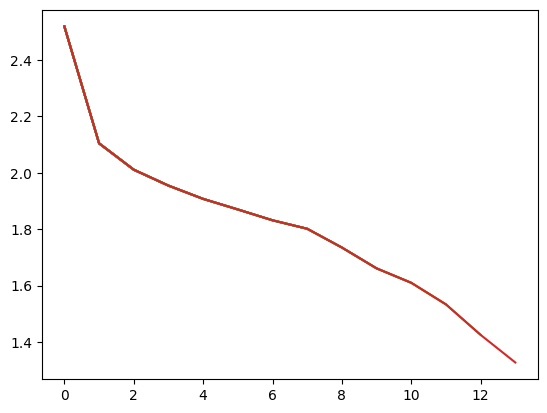

In [48]:
# PROCESS P: 
transformer.train()
transformer.to(device)
total_loss = 0
num_epochs = 20
epoch_loss_data = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    batch_losses = []
    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, tag_batch = batch
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, tag_batch)
        optim.zero_grad()
        tag_predictions = transformer(eng_batch,
                                     tag_batch,
                                      encoder_self_attention_mask.to(device), 
                                     decoder_self_attention_mask.to(device), 
                                     decoder_cross_attention_mask.to(device),
                                     enc_start=False,
                                     enc_end=False,
                                     dec_start=True,
                                     dec_end=True)
        labels = transformer.decoder.sentence_embedding.batch_tokenize(tag_batch, start=False, end=True)
        loss = cross_entropy_loss(
            tag_predictions.view(-1, tag_vocab_size).to(device),
            labels.view(-1).to(device),
            ignore_index=tagalog_to_index[padding]
        )

        valid_indicies = torch.where(labels.view(-1) == tagalog_to_index[padding], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()

        # Calculate and store the loss for the current batch
        batch_losses.append(loss.item())

        #train_losses.append(loss.item())
        if batch_num % 100 == 0:
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"English Senence: {eng_batch[0]}")
            print(f"Actual Tagalog Translation: {tag_batch[0]}")
            tag_sentence_predicted = torch.argmax(tag_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in tag_sentence_predicted:
                if idx == tagalog_to_index[end]:
                    break
                predicted_sentence += index_to_tagalog[idx.item()]
            print(f"Tagalog Prediction: {predicted_sentence}")
            print("__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________")


    # Calculate and store the average loss for the current epoch
    epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_loss_data.append(epoch_loss)

    # Printing and plotting of loss per epoch
    print(f'Average loss for epoch {epoch + 1}: ', epoch_loss)
    plt.plot(epoch_loss_data, label=f'Epoch {epoch + 1}')
# Plot showing
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()
